In [3]:
import numpy as np
import pandas as pd
from dl_biology.cafa6.embedding import aa_encoder
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from dl_biology.cafa6.model import TransformerEncoderRt
from dl_biology.cafa6.dataloader import PeptideDataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
%load_ext autoreload
%autoreload 2


In [4]:
# import data first
filepath = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction/test.csv"
test_data = pd.read_csv(filepath)

filepath = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction/train.csv"
train_data = pd.read_csv(filepath)
X_train = train_data[["PeptideSequence", "Modifications"]].iloc[:8000]
y_train = train_data[["RetentionTime"]].iloc[:8000]

X_val = train_data[["PeptideSequence", "Modifications"]].iloc[8000:]
y_val = train_data[["RetentionTime"]].iloc[8000:]

X_test = test_data[["PeptideSequence", "Modifications"]]
y_test = test_data[["ID"]]

In [5]:
# lets create a vocab
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

vocab = set(list(train_data["PeptideSequence"].sum()))
def aa_encoder(seq, vocab=None):
    """
    Encode the aa in a numerical representation
    e.g. "ACD" -> 012
    """
    if vocab is None:
        vocab = amino_acids
    amino_acid_dict = {aa: idx for idx, aa in enumerate(vocab)}
    if isinstance(seq, list):
        return [amino_acid_dict[aa] for aa in seq]

    elif isinstance(seq, str):
        return [amino_acid_dict[aa] for aa in list(seq)]

# collect all PeptideSequences and encode them
encoded_pep_seq_train = [torch.tensor(aa_encoder(peptide, vocab), dtype=torch.int) for peptide in X_train["PeptideSequence"]]
encoded_pep_seq_val = [torch.tensor(aa_encoder(peptide, vocab), dtype=torch.int) for peptide in X_val["PeptideSequence"]]
encoded_pep_seq_test = [torch.tensor(aa_encoder(peptide, vocab), dtype=torch.int) for peptide in X_test["PeptideSequence"]]

RT mean: 43.65, std: 46.42


/Users/tungvuduc/opt/anaconda3/envs/deep-learning-for-biology/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741997215799/work/aten/src/ATen/NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Epoch [1/40] Train Loss: 0.3120 | Val Loss: 0.1772
Epoch [2/40] Train Loss: 0.1718 | Val Loss: 0.1190
Epoch [3/40] Train Loss: 0.1433 | Val Loss: 0.1068
Epoch [4/40] Train Loss: 0.1284 | Val Loss: 0.1081
Epoch [5/40] Train Loss: 0.1187 | Val Loss: 0.0954
Epoch [6/40] Train Loss: 0.1114 | Val Loss: 0.0952
Epoch [7/40] Train Loss: 0.1084 | Val Loss: 0.1221
Epoch [8/40] Train Loss: 0.1062 | Val Loss: 0.0838
Epoch [9/40] Train Loss: 0.0992 | Val Loss: 0.0805
Epoch [10/40] Train Loss: 0.0981 | Val Loss: 0.0960
Epoch [11/40] Train Loss: 0.0943 | Val Loss: 0.0812
Epoch [12/40] Train Loss: 0.0953 | Val Loss: 0.0833
Epoch [13/40] Train Loss: 0.0918 | Val Loss: 0.0927
Epoch [14/40] Train Loss: 0.0903 | Val Loss: 0.0854
Epoch [15/40] Train Loss: 0.0896 | Val Loss: 0.0738
Epoch [16/40] Train Loss: 0.0892 | Val Loss: 0.0836
Epoch [17/40] Train Loss: 0.0866 | Val Loss: 0.0936
Epoch [18/40] Train Loss: 0.0821 | Val Loss: 0.0789
Epoch [19/40] Train Loss: 0.0830 | Val Loss: 0.0773
Epoch [20/40] Train L

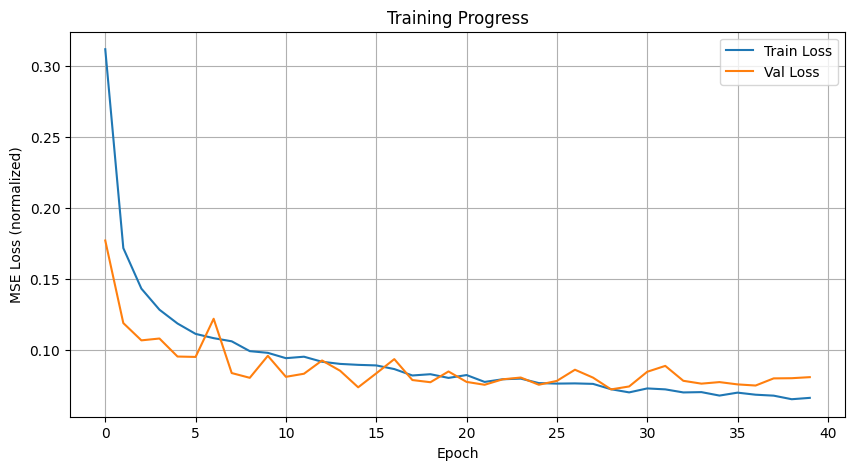


Sample predictions (denormalized):
True: 38.30 | Pred: 46.25
True: -8.85 | Pred: -9.88
True: 132.05 | Pred: 128.10
True: -18.06 | Pred: -2.69
True: 67.93 | Pred: 66.20


In [ ]:
# ============= Some settings =============

d_model = 64
max_len=100
dim_feedforward=256
nhead=4
dropout=0.1
num_layers = 4
batch_size = 32
num_epochs = 40
lr = 0.0005
# train the model
def collate_fn(batch):
    """Custom collate function for variable-length peptide sequences"""
    # Extract sequences and convert to tensors if needed
    sequences = [item["pep_seq"] for item in batch]
    rts = torch.tensor([item["rt"] for item in batch], dtype=torch.float32)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    return {
        "pep_seq": sequences_padded,
        "rt": rts,
        "lengths": lengths
    }

# ============= 1. NORMALIZE YOUR TARGETS =============
# This is CRITICAL for training stability
rt_mean = y_train.values.mean()
rt_std = y_train.values.std()

print(f"RT mean: {rt_mean:.2f}, std: {rt_std:.2f}")

y_train_normalized = (y_train.values.flatten() - rt_mean) / rt_std
y_val_normalized = (y_val.values.flatten() - rt_mean) / rt_std

# ============= 2. CREATE DATASETS WITH NORMALIZED DATA =============
train_dataset = PeptideDataset(encoded_pep_seq_train, y_train_normalized)
val_dataset = PeptideDataset(encoded_pep_seq_val, y_val_normalized)
test_dataset = PeptideDataset(encoded_pep_seq_test, y_test.values)

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# ============= 3. INITIALIZE MODEL =============
vocab_size = len(vocab)

model = TransformerEncoderRt(vocab_size=vocab_size, d_model=d_model, num_layers=num_layers, dim_feedforward=dim_feedforward, nhead=nhead, dropout=dropout, max_len=max_len, )

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ============= 5. PROPER TRAINING LOOP =============
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ===== TRAINING =====
    model.train()
    train_loss = 0
    
    for batch in dataloader_train:
        seq = batch["pep_seq"]
        rt = batch["rt"]
        lengths = batch["lengths"]
        
        # Forward pass
        output = model(seq, lengths)
        loss = criterion(output, rt)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    
    # ===== VALIDATION =====
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in dataloader_val:
            seq = batch["pep_seq"]
            rt = batch["rt"]
            lengths = batch["lengths"]
            
            output = model(seq, lengths)
            loss = criterion(output, rt)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# ============= 6. PLOT LEARNING CURVES =============
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (normalized)')
plt.legend()
plt.title('Training Progress')
plt.grid(True)
plt.show()

# ============= 7. TEST PREDICTIONS =============
model.eval()
with torch.no_grad():
    test_batch = next(iter(dataloader_val))
    seq = test_batch["pep_seq"]
    rt_true = test_batch["rt"]
    lengths = test_batch["lengths"]
    
    rt_pred = model(seq, lengths)
    
    # Denormalize for comparison
    rt_true_denorm = rt_true * rt_std + rt_mean
    rt_pred_denorm = rt_pred * rt_std + rt_mean
    
    print("\nSample predictions (denormalized):")
    for i in range(min(5, len(rt_true))):
        print(f"True: {rt_true_denorm[i].item():.2f} | Pred: {rt_pred_denorm[i].item():.2f}")

In [13]:
# perform the validation prediction for all val RTs
model.eval()
rt_preds = []
with torch.no_grad():
    for batch in dataloader_val:

        seq = batch["pep_seq"]
        rt_true = batch["rt"]
        lengths = batch["lengths"]
    
        rt_pred = model(seq, lengths)
    
        # Denormalize for comparison
        rt_pred_denorm = rt_pred * rt_std + rt_mean
        rt_preds.append(rt_pred_denorm)

Pearon corr:  0.9594988436027135
MAE 9.238786676165132


/var/folders/8z/k5tph_7d3cd3tq2s362kbfch0000gn/T/ipykernel_41316/192711063.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rt_preds = np.array(torch.cat(rt_preds))


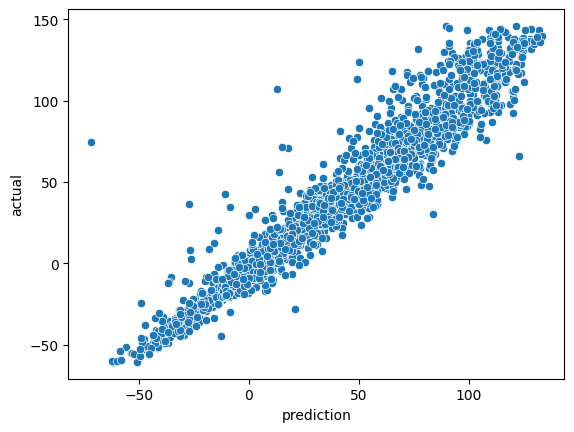

In [14]:
rt_preds = np.array(torch.cat(rt_preds))
y_pred = rt_preds
y_true = y_val.values.flatten()
sns.scatterplot(
    x=y_pred,
    y=y_true
)
plt.xlabel("prediction")
plt.ylabel("actual")
print("Pearon corr: ", np.corrcoef(y_pred, y_true)[0, -1])
def mae(y_pred, y):
    return np.mean(np.abs(y_pred -y))
print(f"MAE {mae(y_pred, y_true)}")

In [15]:
# perform the test prediction for all val RTs
model.eval()
rt_preds_test = []
with torch.no_grad():
    for batch in dataloader_test:

        seq = batch["pep_seq"]
        rt_true = batch["rt"]
        lengths = batch["lengths"]
    
        rt_pred = model(seq, lengths)
    
        # Denormalize for comparison
        rt_pred_denorm = rt_pred * rt_std + rt_mean
        rt_preds_test.append(rt_pred_denorm)

In [17]:
rt_pred_tests = np.array(torch.concat(rt_preds_test))
rt_prediction_rnn_embedding = pd.DataFrame(
    data=rt_pred_tests, columns=["RetentionTime"]
)
rt_prediction_rnn_embedding["ID"] = test_data["ID"]

path = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction"
path = os.path.join(path, "rt_pred_transformer.csv")
rt_prediction_rnn_embedding.sort_index(axis=1).to_csv(path, index=False)

/var/folders/8z/k5tph_7d3cd3tq2s362kbfch0000gn/T/ipykernel_41316/645334562.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rt_pred_tests = np.array(torch.concat(rt_preds_test))
